Original  Image


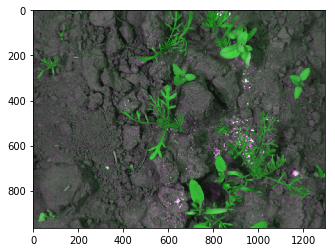

remove Red and Blue band


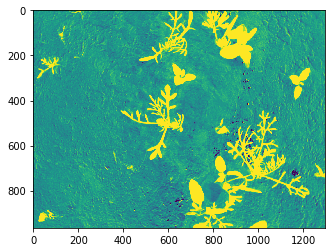

Masking image


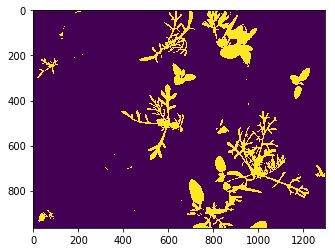

uint8


In [76]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 



#read image 
p = cv2.imread('./crop-image/crop-weed01.png')

# # %Red Component of Colour Image
# p_red = p[:,:,0]
# # %Green Component of Colour Image
# p_green= p[:,:,1]
# # %Blue Component of Colour Image
# p_blue= p[:,:,2]

p_blue, p_green, p_red= cv2.split(p) # For BGR image # For RGB image

# subtract out red and blue
#wrap around uint8 convention. this is a requrement for this algorithm 
# 0 - 4 = 0 (uint8 truncated)
p_excess_green = 128 + np.int16(p_green) - np.int16(p_blue) + np.int16(p_green) - np.int16(p_red)
p_excess_green = np.uint8(np.clip(p_excess_green, 0, 255))

mask = np.uint8((p_excess_green > 230)*1)


# hist = cv2.calcHist([p_excess_green],[0],None,[256],[0,256])
# plt.hist(p_excess_green.ravel(),256,[0,256])
# plt.show()

print("Original  Image")
plt.imshow(p)
plt.show()

print("remove Red and Blue band")
plt.imshow(p_excess_green)
plt.show()


print("Masking image")
plt.imshow(mask)
plt.show()

print(mask.dtype)


Draw contour


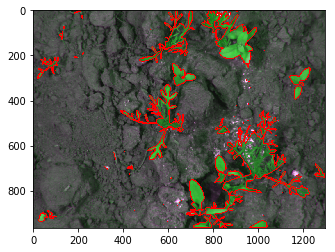

In [77]:
# #thresh hold for binary image 1,0
# thresh, im_bw = cv2.threshold(mask, 0, 1, cv2.THRESH_BINARY) #im_bw: binary image

p_contoured = p.copy()
#base on: https://mmeysenburg.github.io/image-processing/09-contours/
#cv2.RETR_TREE: mean all contour in the image 
#RETR_EXTERNAL: mean outer edge
im3, contours, hierarchy = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

#image with contours
print("Draw contour")
cv2.drawContours(p_contoured, contours, -1, (255,0,0), 3)
plt.imshow(p_contoured)
plt.show()

## Box Contour
- Find all boxes.
- remove overlaping boxes

### Find all boxes given contours vector 

Draw all Box on the screen


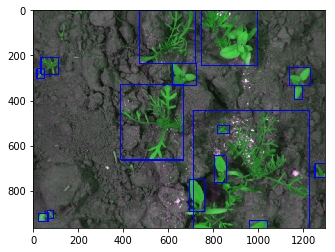

16
[(959, 934, 80, 32), (24, 900, 42, 38), (62, 887, 30, 37), (693, 750, 67, 141), (1251, 681, 45, 61), (805, 646, 52, 118), (817, 513, 56, 35), (711, 446, 516, 520), (1159, 335, 35, 61), (389, 330, 279, 334), (17, 260, 32, 43), (1138, 256, 92, 78), (619, 237, 105, 97), (35, 209, 79, 75), (749, 0, 245, 246), (471, 0, 248, 235)]


In [78]:
#Get all bounding boxes 
boxes = []
for c in contours: 
    x,y,w,h = cv2.boundingRect(c)
    if(w > 20 and h > 20):#don't box item if it is too small 
        boxes.append((x,y,w,h))#(x,y,w,h)

p_temp = p.copy()
#Draw all boxes on the screen 
for box in boxes: 
    cv2.rectangle(p_temp,(box[0],box[1]), (box[0]+box[2], box[1]+box[3]), (0,0,255), 4)

print("Draw all Box on the screen")
plt.imshow(p_temp)
plt.show()

print(len(boxes))
print(boxes)


### Remove Overlaping boxes 

13
[(17, 260, 32, 43), (24, 900, 42, 38), (35, 209, 79, 75), (62, 887, 30, 37), (389, 330, 279, 334), (471, 0, 248, 235), (619, 237, 105, 97), (693, 750, 67, 141), (711, 446, 516, 520), (959, 934, 80, 32), (1138, 256, 92, 78), (1159, 335, 35, 61), (1251, 681, 45, 61)]


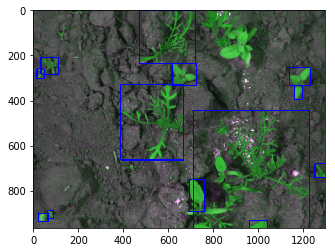

In [79]:
def isOverlap(box1, box2):
    w =  min(box1[0]+box1[2], box2[0]+box2[2])- max(box1[0], box2[1])
    h = min(box1[1]+box1[3], box2[1]+box2[3]) - max(box1[1], box2[1])
    if(w < 0 or h < 0):
        return False 
    return True

'''
assume rect is sort in x, box1.x < box2.x
if box1 > box2(box2 enclosed in box1) -> return 1 
else: 0
'''
def is_enclosed(box1, box2): 
    if(box1[0]+box1[2] > box2[0]+box2[2] and box1[1]+box1[3] > box2[1]+box2[3]):# check box x and y 
        return True
    else: return False
        

def remove_overlap(boxes):
    i = 0
    j = 0
    if(len(boxes) == 1): 
        return None
    while(j < len(boxes)-1):
        if(is_enclosed(boxes[j], boxes[j+1])):
            boxes.remove(boxes[j+1])
        else: 
            j += 1

            
#sort boxes by x 
boxes.sort(key=lambda tup: tup[0])  # sorts in place
            
remove_overlap(boxes)
print(len(boxes))
print(boxes)
p_boxed = p.copy()

for box in boxes:
    cv2.rectangle(p_boxed,(box[0],box[1]), (box[0]+box[2], box[1]+box[3]), (0,0,255), 4)# 4: 4 edges

plt.imshow(p_boxed)
plt.show()

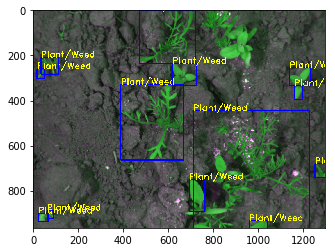

In [88]:
# put text on image 
font                   = cv2.FONT_HERSHEY_DUPLEX
bottomLeftCornerOfText = (10,500)
fontScale              = 1.3
fontColor              = (255,255,0)
lineType               = 2

p_texted = p.copy()
for box in boxes:
    cv2.rectangle(p_texted,(box[0],box[1]), (box[0]+box[2], box[1]+box[3]), (0,0,255), 4)# 4: 4 edges
    cv2.putText(p_texted,'Plant/Weed', 
                (box[0],box[1]), # bottom left corner
                font, 
                fontScale,
                fontColor,
                lineType)
    
plt.imshow(p_texted)
plt.show()